In [68]:
%matplotlib widget

import sys, glob, yaml
sys.path.append('../toolbox/')
sys.path.append('../weld')
from lambda_calc import *
from multi_robot import *
from dx200_motion_program_exec_client import *
from WeldSend import *
from RobotRaconteur.Client import *
from weldRRSensor import *
from motoman_def import *
from flir_toolbox import *
import weld_dh2v
import matplotlib.pyplot as plt

from datetime import datetime
import re
import numpy_indexed as npi
from numpy.linalg import norm
from scipy.optimize import minimize, Bounds
from scipy.signal import savgol_filter

def get_trailing_number(s):
    m = re.search(r'\d+$', s)
    return int(m.group()) if m else None

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy
    
def avg_by_line(job_line, flame_pos, num_segs):
    ref_idx = job_line[0]
    job_line_unique = [ref_idx]
    idx = 0
    num_points = 0
    average_pos = []
    sum = np.zeros(flame_pos.shape[1])
    while True:
        while job_line[idx] == ref_idx:
            sum = sum + flame_pos[idx,:]
            num_points += 1
            idx+=1
            if idx >= len(job_line): break
        
        average_pos.append(sum/num_points)
        sum = np.zeros(flame_pos.shape[1])
        try:
            ref_idx = job_line[idx]
            job_line_unique.append(ref_idx)
        except:
            break
        num_points = 0
    average_pos = np.array(average_pos)
    output = np.empty((num_segs, 3))
    
    # for i, line_no in enumerate(job_line_unique):
    #     output[line_no,1:] = average_pos[i,:]
    #     output[line_no,0] = line_no
    for i in range(num_segs):
         if i in job_line_unique:
              idx = job_line_unique.index(i)
              output[i,:] = average_pos[idx, :]
         else:
              output[i,:] = [None, None, None]
    #handle missing height data

    return output

def interpolate_heights(sparse_height):
     for i, height in enumerate(sparse_height):
        if np.isnan(height):
             prev_height = sparse_height[i-1]
             #search for next nan number
             for j, height_check in enumerate(sparse_height[i:]):
                  if not np.isnan(height_check):
                       idx_dif = j+1
                       height_dif = (prev_height-height_check)
                       for k in range(idx_dif):
                            sparse_height[i+k] = prev_height - height_dif*(k+1)/idx_dif
                       break
                  elif i+j == len(sparse_height)-1:
                       idx_dif = j+1
                       height_dif = (prev_height-0)
                       for k in range(idx_dif):
                            sparse_height[i+k] = prev_height - height_dif*(k+1)/idx_dif
     return sparse_height
x=0
layer = 50


dataset='bent_tube/'
sliced_alg='slice_ER_4043/'
data_dir='../data/'+dataset+sliced_alg

with open(data_dir+'slicing.yml', 'r') as file:
	slicing_meta = yaml.safe_load(file)
base_thickness = slicing_meta['baselayer_thickness']

def flame_detection_aluminum(raw_img,threshold=1.0e4,area_threshold=4,percentage_threshold=0.8):
    ###flame detection by raw counts thresholding and connected components labeling
    #centroids: x,y
    #bbox: x,y,w,h
    ###adaptively increase the threshold to 60% of the maximum pixel value
    threshold=max(threshold,percentage_threshold*np.max(raw_img))
    thresholded_img=(raw_img>threshold).astype(np.uint8)

    nb_components, labels, stats, centroids = cv2.connectedComponentsWithStats(thresholded_img, connectivity=4)
    
    valid_indices=np.where(stats[:, cv2.CC_STAT_AREA] > area_threshold)[0][1:]  ###threshold connected area
    if len(valid_indices)==0:
        return None, None, None, None
    
    average_pixel_values = [np.mean(raw_img[labels == label]) for label in valid_indices]   ###sorting
    valid_index=valid_indices[np.argmax(average_pixel_values)]      ###get the area with largest average brightness value

    # Extract the centroid and bounding box of the largest component
    centroid = centroids[valid_index]
    bbox = stats[valid_index, :-1]

    return centroid, bbox

robot=robot_obj('MA2010_A0',def_path='../config/MA2010_A0_robot_default_config.yml',tool_file_path='../config/torch.csv',\
	pulse2deg_file_path='../config/MA2010_A0_pulse2deg_real.csv',d=15)
robot2=robot_obj('MA1440_A0',def_path='../config/MA1440_A0_robot_default_config.yml',tool_file_path='../config/flir.csv',\
	pulse2deg_file_path='../config/MA1440_A0_pulse2deg_real.csv',base_transformation_file='../config/MA1440_pose.csv')
positioner=positioner_obj('D500B',def_path='../config/D500B_robot_extended_config.yml',tool_file_path='../config/positioner_tcp.csv',\
	pulse2deg_file_path='../config/D500B_pulse2deg_real.csv',base_transformation_file='../config/D500B_pose.csv')

config_dir='../config/'
flir_intrinsic=yaml.load(open(config_dir+'FLIR_A320.yaml'), Loader=yaml.FullLoader)
with open(data_dir+'slicing.yml', 'r') as file:
	slicing_meta = yaml.safe_load(file)
por = slicing_meta['point_of_rotation']
angle = slicing_meta['layer_angle']
print(angle)


save_path = f'../../recorded_data/ER4043_bent_tube_2024_08_01_11_47_23/layer_{layer}/'

with open(save_path+'ir_recording.pickle', 'rb') as file:
        ir_recording = pickle.load(file)



H = np.loadtxt(data_dir+'curve_pose.csv', delimiter=',')
print(H)

1.1257976619508032
[[-2.46887427e-01 -9.69044167e-01  0.00000000e+00  8.85847192e-16]
 [ 9.69044167e-01 -2.46887427e-01  0.00000000e+00  3.72339150e-16]
 [-0.00000000e+00 -0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


0
1269


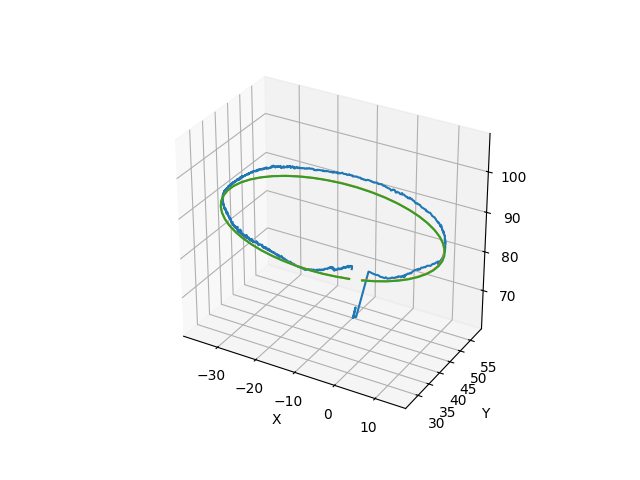

In [69]:
flame_3d=[]
job_no = []
torch_path = []
ir_ts=np.loadtxt(save_path+'ir_stamps.csv', delimiter=',')
curve_sliced_relative=np.loadtxt(data_dir+'curve_sliced_relative/slice'+str(layer)+'_0.csv',delimiter=',')
curve_sliced_relative = curve_sliced_relative[:,0:3]
if len(ir_ts)>0:
    joint_angle=np.loadtxt(save_path+'weld_js_exe.csv', delimiter=',')

    timeslot=[ir_ts[0]-ir_ts[0], ir_ts[-1]-ir_ts[0]]
    duration=np.mean(np.diff(timeslot))


    for start_time in timeslot[:-1]:
        
        start_idx=np.argmin(np.abs(ir_ts-ir_ts[0]-start_time))
        end_idx=np.argmin(np.abs(ir_ts-ir_ts[0]-start_time-duration))
        print(start_idx)
        print(end_idx)

        #find all pixel regions to record from flame detection
        for i in range(start_idx,end_idx):
            
            ir_image = ir_recording[i]
            try:
                centroid, bbox=flame_detection_aluminum(ir_image, percentage_threshold=0.8)
            except ValueError:
                centroid = None
            if centroid is not None:
                #find spatial vector ray from camera sensor
                vector=np.array([(centroid[0]-flir_intrinsic['c0'])/flir_intrinsic['fsx'],(centroid[1]-flir_intrinsic['r0'])/flir_intrinsic['fsy'],1])
                vector=vector/np.linalg.norm(vector)
                #find index closest in time of joint_angle
                joint_idx=np.argmin(np.abs(ir_ts[i]-joint_angle[:,0]))
                robot2_pose_world=robot2.fwd(joint_angle[joint_idx][8:-2],world=True)
                p2=robot2_pose_world.p
                v2=robot2_pose_world.R@vector
                robot1_pose=robot.fwd(joint_angle[joint_idx][2:8])
                p1=robot1_pose.p
                v1=robot1_pose.R[:,2]
                positioner_pose=positioner.fwd(joint_angle[joint_idx][-2:], world=True)

                #find intersection point
                intersection=line_intersect(p1,v1,p2,v2)
                # Convert to positioner frame
                
                intersection = positioner_pose.R.T@(intersection-positioner_pose.p)
                torch = positioner_pose.R.T@(robot1_pose.p-positioner_pose.p)

                torch_path.append(torch)
                flame_3d.append(intersection)
                job_no.append(int(joint_angle[joint_idx][1]))
flame_3d = np.array(flame_3d)
torch_path = np.array(torch_path)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(flame_3d[:,0], flame_3d[:,1], flame_3d[:,2])
ax.plot3D(torch_path[:,0], torch_path[:,1], torch_path[:,2])
ax.plot3D(curve_sliced_relative[:,0], curve_sliced_relative[:,1], curve_sliced_relative[:,2])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_aspect('equal')
plt.show()


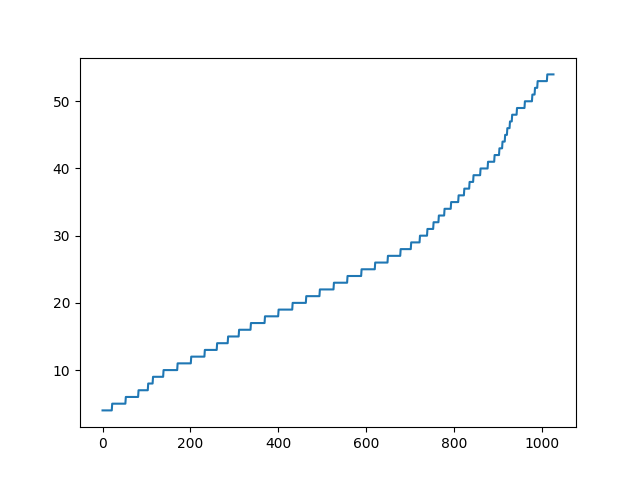

Min Job no:  4
Max Job no:  54
Job Len:  1028
Flame len:  1028


In [70]:
fig,ax = plt.subplots()
ax.plot(job_no)
plt.show()
print("Min Job no: ", job_no[0])
print("Max Job no: ", job_no[-1])
print("Job Len: ", len(job_no))
print("Flame len: ", len(flame_3d))

[[-0.24688743  0.96904417 -0.        ]
 [-0.96904417 -0.24688743 -0.        ]
 [ 0.          0.          1.        ]]


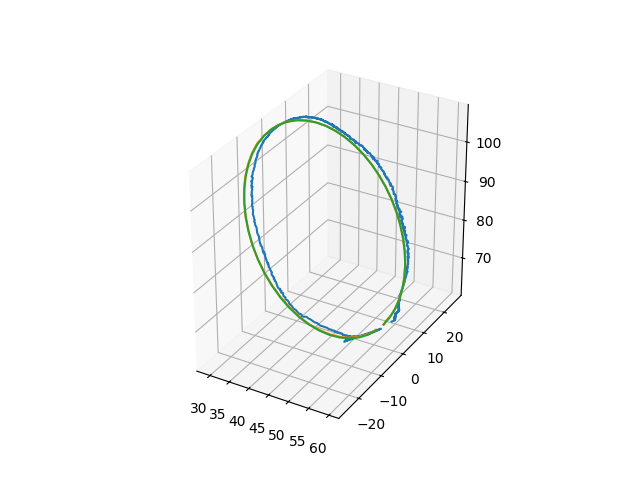

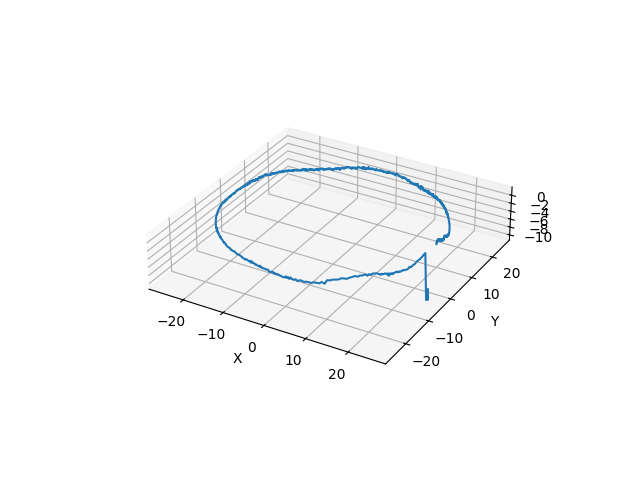

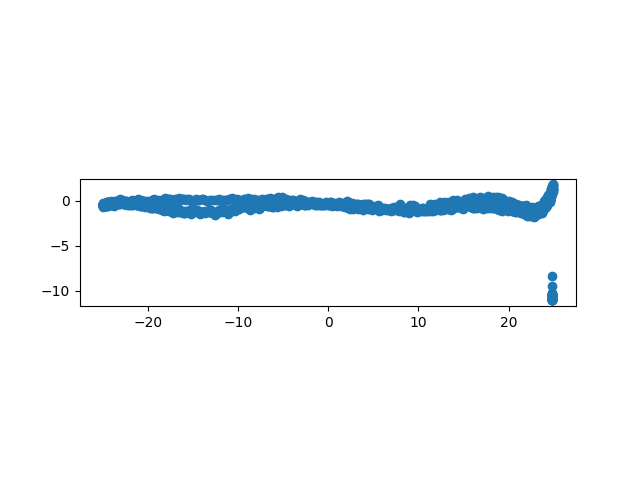

In [71]:
p = H[:3, -1]
R = H[:3, :3]
print(R.T)
# torch_path[:, -1] = torch_path[:,-1]
# flame_3d[:, -1] = flame_3d[:, -1]
#convert back to designed part frame
for i in range(flame_3d.shape[0]):
    torch_path[i] = R.T@torch_path[i]
    flame_3d[i] = R.T@flame_3d[i]
for i in range(curve_sliced_relative.shape[0]):
    curve_sliced_relative[i] = R.T@curve_sliced_relative[i]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(flame_3d[:,0], flame_3d[:,1], flame_3d[:,2])
ax.plot3D(torch_path[:,0], torch_path[:,1], torch_path[:,2])
ax.plot3D(curve_sliced_relative[:,0], curve_sliced_relative[:,1], curve_sliced_relative[:,2])
ax.set_aspect('equal')
plt.show()
layer_angle = angle*(layer)
layer_angle=np.deg2rad(layer_angle)
new_x, new_z = rotate((por,base_thickness), (flame_3d[:,0], flame_3d[:,2]), layer_angle)
flame_3d[:,0] = new_x
flame_3d[:,2] = new_z-base_thickness

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(flame_3d[:,0], flame_3d[:,1], flame_3d[:,2])
ax.set_aspect('equal')

ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()
fig,ax = plt.subplots()
ax.scatter(flame_3d[:,0], flame_3d[:, -1])
ax.set_aspect('equal')
plt.show()

[24.75090019 -3.38841546 -8.8226043 ]
(50, 3)


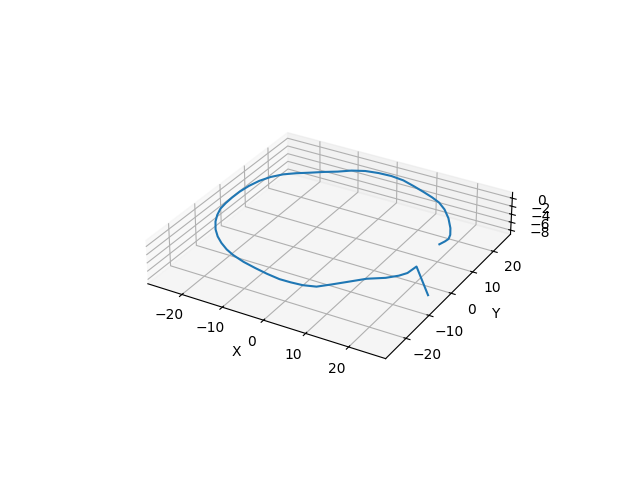

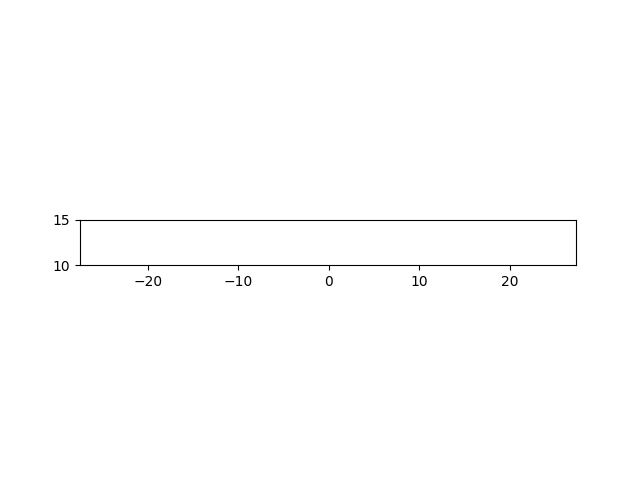

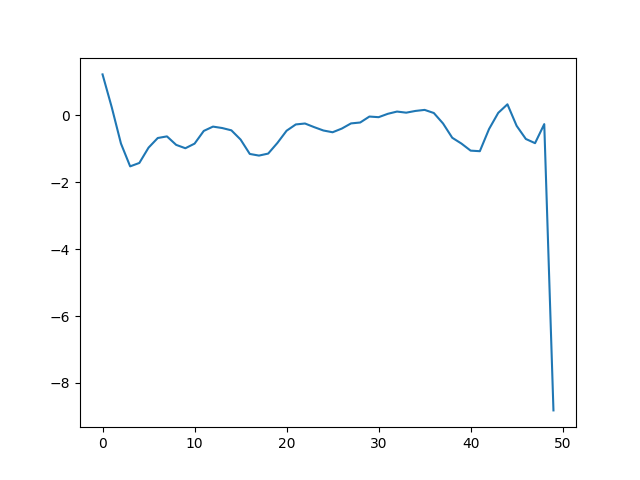

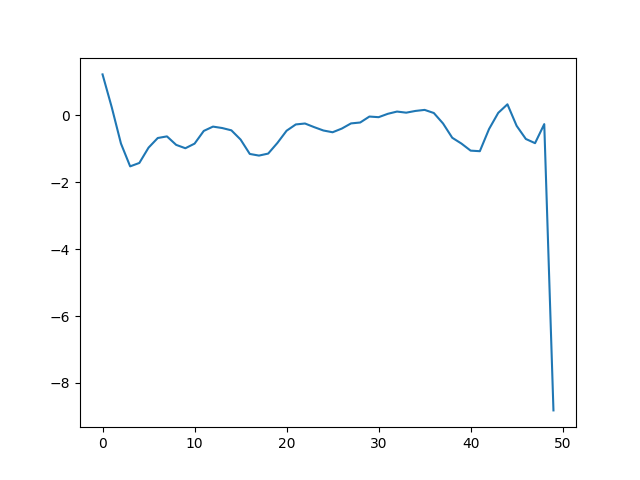

In [72]:
job_no = [i-4 for i in job_no]
averages = avg_by_line(job_no, flame_3d, 50)
print(averages[49,:])
print(averages.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(averages[:,0], averages[:,1], averages[:,2])
ax.set_aspect('equal')
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()
fig,ax = plt.subplots()
ax.scatter(averages[:,0], averages[:, -1])
ax.set_ylim(10,15)
ax.set_aspect('equal')
plt.show()

# height_plot
heights = averages[:,-1]
fig,ax = plt.subplots()
ax.plot(heights)
plt.show()
heights = interpolate_heights(heights)
fig,ax = plt.subplots()
ax.plot(heights)
plt.show()


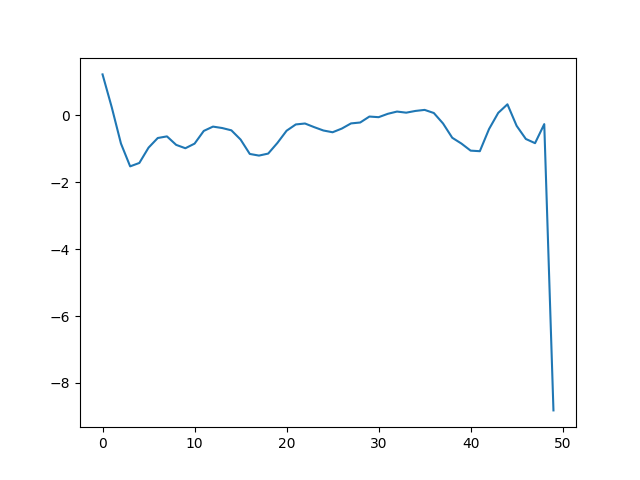

In [73]:
# Test comparison and corrective action
height_profile = [1.485748029575696, 1.4896208739275099, 1.501178340276121, 1.5202381901391202, 1.5464998833060943, 
                  1.5795493118364596, 1.6188653244168523, 1.6638279392291109, 1.7137281165972886, 1.7677789377172721, 
                  1.825128013240307, 1.8848709258191603, 1.9460654942724445, 2.0077466340263688, 2.0689415791256445, 
                  2.128685225478, 2.1860353531696233, 2.240087487672689, 2.289989165521385, 2.334953379467082, 
                  2.3742709910897863, 2.407321915140878, 2.4335848992678666, 2.4526457449230663, 2.4642038398376536, 
                  2.4680768990643953, 2.4642038398376536, 2.4526457449230663, 2.433584899267866, 2.407321915140878, 
                  2.3742709910897863, 2.334953379467082, 2.289989165521385, 2.2400874876726884, 2.1860353531696233, 
                  2.128685225478, 2.0689415791256445, 2.0077466340263688, 1.9460654942724445, 1.8848709258191598, 
                  1.8251280132403076, 1.7677789377172721, 1.7137281165972886, 1.6638279392291109, 1.6188653244168518,
                  1.5795493118364596, 1.5464998833060943, 1.5202381901391202, 1.501178340276121, 1.4896208739275099]
vel_nom = [15.00757638, 14.92323149, 14.6756067,  14.28017187, 13.76036119, 13.14462691,
 12.46326183, 11.74555556, 11.01766062, 10.30131158,  9.61334194,  8.96582304,
  8.36660724,  7.8200743 ,  7.32792693,  6.88993499,  6.50457528,  6.16954832,
  5.88217527,  5.63969017,  5.43944664,  5.27905867,  5.15649293,  5.07012665,
  5.01878231,  5.00174705,  5.01878231,  5.07012665,  5.15649293,  5.27905867,
  5.43944664,  5.63969017,  5.88217527,  6.16954832,  6.50457528,  6.88993499,
  7.32792693,  7.8200743,   8.36660724,  8.96582304,  9.61334194, 10.30131158,
 11.01766062, 11.74555556, 12.46326183, 13.14462691, 13.76036119, 14.28017187,
 14.6756067,  14.92323149]
fig,ax = plt.subplots()
ax.plot(heights)
# ax.plot(height_profile)

[17.         16.54406876  4.76682786  3.          3.          4.05274786
  4.96420022  4.98002744  3.8957512   3.47509353  3.68425068  4.74266791
  5.02420734  4.60013959  4.14248002  3.23684165  3.          3.
  3.          3.          3.2778047   3.66237411  3.66635129  3.34367207
  3.09583118  3.          3.21970664  3.62326999  3.74922493  4.39330745
  4.44366605  4.99681033  5.51809602  5.60245336  6.18622756  6.75032949
  6.52926375  5.16843263  3.8392774   3.53164274  3.17440738  3.26471261
  5.79619656 10.26576155 15.52873602  7.26258237  5.15525595  4.735214
  8.36292259  3.        ]
[17.         16.54406876  4.76682786  3.          3.          4.05274786
  4.96420022  4.98002744  3.8957512   3.47509353  3.68425068  4.74266791
  5.02420734  4.60013959  4.14248002  3.23684165  3.          3.
  3.          3.          3.2778047   3.66237411  3.66635129  3.34367207
  3.09583118  3.          3.21970664  3.62326999  3.74922493  4.39330745
  4.44366605  4.99681033  5.51809602  5.602

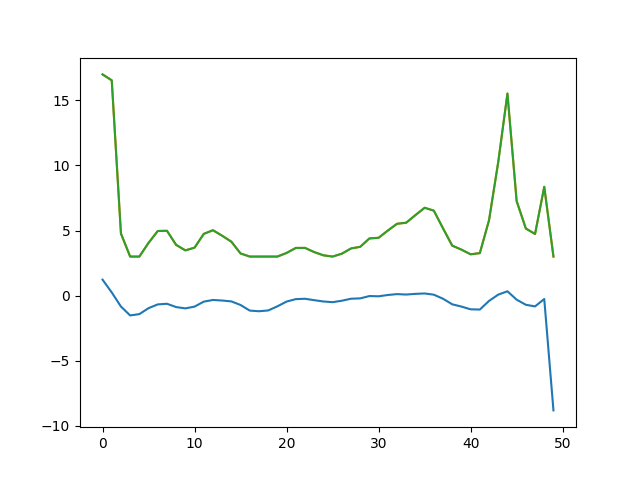

In [74]:
def v_opt(v_next, h_err, h_targ, lam=None):
    return norm(h_targ+h_err-weld_dh2v.v2dh_loglog(v_next), 2)**2
bounds = Bounds(3, 17)

height_err = 0-heights
opt_result=minimize(v_opt, vel_nom, (height_err, height_profile), bounds=bounds,
                    options = {'maxfun':100000})
if not opt_result.success: 
    print(opt_result)
    raise ValueError(opt_result.message)
vel_profile =opt_result.x


print(vel_profile)
plt.plot(vel_profile)
#vel_profile = savgol_filter(vel_profile, int(len(vel_profile)/12), 1, mode='nearest')
print(vel_profile)
plt.plot(vel_profile)
plt.show()

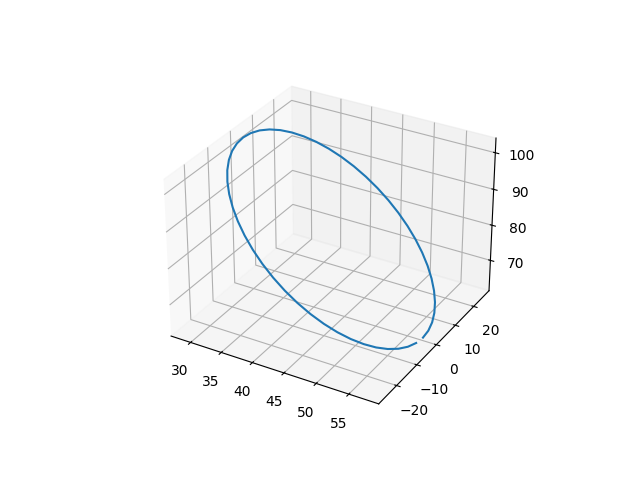

100.6131657840027
56.28988309754016
[ 25.01459583  24.81750142  24.22932647  23.25934687  21.92285976
  20.24094234  18.24011947  15.9519453   13.41250573  10.66184921
   7.74335525   4.70305025   1.58888163  -1.55003832  -4.66420694
  -7.70451194 -10.6230059  -13.37366241 -15.91310199 -18.20127616
 -20.20209903 -21.88401644 -23.22050355 -24.19048316 -24.77865811
 -24.97575252 -24.77865811 -24.19048316 -23.22050355 -21.88401644
 -20.20209903 -18.20127616 -15.91310199 -13.37366241 -10.6230059
  -7.70451194  -4.66420694  -1.55003832   1.58888163   4.70305025
   7.74335525  10.66184921  13.41250573  15.9519453   18.24011947
  20.24094234  21.92285976  23.25934687  24.22932647  24.81750142]
[-1.48561811 -1.4894913  -1.50104976 -1.52011122 -1.54637507 -1.57942711
 -1.61874609 -1.66371193 -1.71361548 -1.76766975 -1.82502226 -1.88476852
 -1.94596631 -2.0076505  -2.06884829 -2.12859455 -2.18594706 -2.24000132
 -2.28990488 -2.33487071 -2.3741897  -2.40724174 -2.43350559 -2.45256705
 -2.46412551

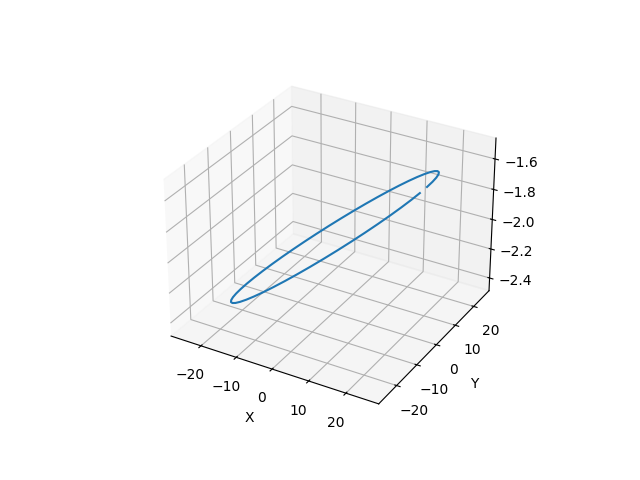

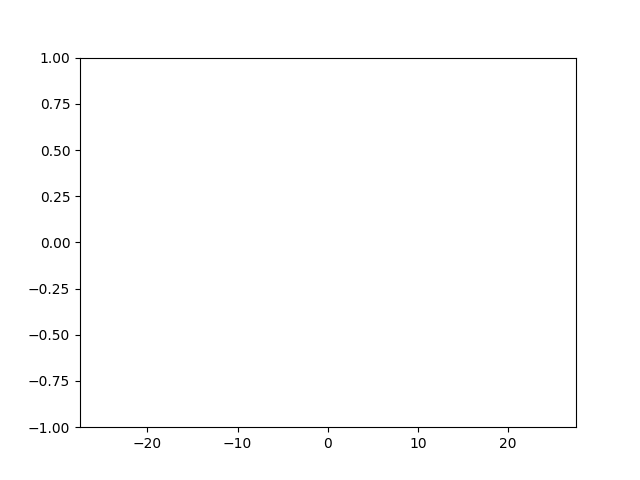

In [75]:
curve_sliced_relative=np.loadtxt(data_dir+'curve_sliced_relative/slice'+str(layer)+'_0.csv',delimiter=',')
curve_sliced_relative = curve_sliced_relative[:,0:3]


p = H[:3, -1]
R = H[:3, :3]
R_inv = np.linalg.inv(R)
curve_sliced_relative[:, -1] = curve_sliced_relative[:, -1]-4
#convert back to designed part frame
for i in range(curve_sliced_relative.shape[0]):
    curve_sliced_relative[i] = R_inv@curve_sliced_relative[i]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(curve_sliced_relative[:,0], curve_sliced_relative[:,1], curve_sliced_relative[:,2])
plt.show()
print(por)
layer_angle = angle*(layer)
print(layer_angle)
layer_angle=np.deg2rad(layer_angle)
new_x, new_z = rotate((por,0), (curve_sliced_relative[:,0], curve_sliced_relative[:,2]), layer_angle)
print(new_x)
print(new_z)
curve_sliced_relative[:,0] = new_x
curve_sliced_relative[:,2] = new_z

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(curve_sliced_relative[:,0], curve_sliced_relative[:,1], curve_sliced_relative[:,2])
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()
fig, ax = plt.subplots()
ax.scatter(curve_sliced_relative[:,0], curve_sliced_relative[:, -1])
ax.set_ylim(-1,1)
plt.show()